# Sanity checks for surface raditaion

In [1]:
%matplotlib inline
from typing import Optional

from cartopy import crs
import numpy as np
from matplotlib import pyplot as plt
import freva
import xarray as xr

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
def get_rotated_pole(dset: xr.Dataset) -> Optional[tuple[float, float]]:
    """Get the coordinates of a rocted pole, if none given return None."""
    rot_pole_var = [v for v in map(str, dset.data_vars) if "rotated" in v]
    if rot_pole_var:
        pole = dset[rot_pole_var[0]].attrs
        return pole["grid_north_pole_longitude"], pole["grid_north_pole_latitude"]
    return None

def transform_points(X: np.ndarray, Y: np.ndarray, source_proj: crs.Projection, target_proj: crs.Projection) -> tuple[np.ndarray, np.ndarray]:
    """Transform points in longitude and laititude array."""
    if len(Y.shape) == 1:
        Y, X = np.meshgrid(Y, X)
    lon_p, lat_p, _ = target_proj.transform_points(source_proj, X, Y).T
    return lon_p, lat_p

def weighted_mean(dataset: xr.Dataset) -> xr.Dataset:
        """Calculate a weighted area average of a input dataset.

        Parameters
        ----------
        dataset: xarray.Dataset
            Input dataset that should be averaged

        Returns
        -------
        xarray.Dataset
            Weighted field mean of the dataset

        """
        lat_name = dataset.dims[-2]
        lon_name = dataset.dims[-1]
        weight = np.cos(np.deg2rad(dataset[lat_name].values))
        if len(dataset[lat_name].shape) == 1:
            _, weight = np.meshgrid(np.ones_like(dataset[lon_name]), weight)
        x_weight = xr.DataArray(
            weight,
            dims=(lat_name, lon_name),
            coords={lon_name: dataset[lon_name], lat_name: dataset[lat_name]},
        )
        return (x_weight * dataset).sum(
            dim=(lat_name, lon_name), keep_attrs=True
        ) / weight.sum()


def plot_comprison(variable: str, *dsets: xr.Dataset, cmap="PuRd") -> None:
    """Plot a comparison of datasets."""
    ncols = len(dsets)
    fig = plt.figure(figsize=(len(dsets) * 4, 6))
    transform = crs.PlateCarree()
    cbar_kwargs={'extend': 'both', 'orientation': 'horizontal'}
    target_proj = crs.PlateCarree()
    for nn, dset in enumerate(dsets):
        dims = dset[variable].dims
        rot_pole = get_rotated_pole(dset)
        if rot_pole:
            proj = crs.RotatedPole(*rot_pole)
        else:
            proj = crs.PlateCarree()
        dims = dset[variable].dims
        #lon, lat = transform_points(dset[dims[-1]], dset[dims[-2]], proj, target_proj)
        lon, lat = (dset["lon"].values), dset["lat"].values
        if nn == 0:
            central_lon = (lon.max() - lon.min()) / 2
            bbox = [lon.min(), lon.max(), lat.min(), lat.max()]
        if rot_pole:
            plot_proj = crs.RotatedPole(*rot_pole, central_lon)
            plot_dset = dset[variable]
        else:
            plot_dset = dset[variable].sel({dims[-1]: slice(*bbox[:2]), dims[-2]: slice(*bbox[2:])})
            plot_proj = crs.PlateCarree(central_lon)
        mean = float(weighted_mean(plot_dset).values)
        vmin, vmax = plot_dset.quantile([0.02, 0.98]).values
        ax = fig.add_subplot(1, len(dsets), nn+1, projection=plot_proj)
        plot_dset.plot(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, transform=proj, vmin=vmin, vmax=vmax)
        ax.coastlines(resolution="10m")
        ax.set_title(f"{dset.attrs['product']} avg: {round(mean, 2)}")
    return ax

In [22]:
# era5 data files
era5_files = freva.databrowser(variable=["rlds", "rsds"], experiment="era5", project="reanalysis", time_frequency="mon", time="2012-01 to 2012-02")

# rea6 data files
rea6_files = freva.databrowser(variable=["rlds", "rsds"], experiment="rea6", project="reanalysis",  time="2012-01 to 2012-02")

# merra files
merra_files = freva.databrowser(variable=["rlds", "rsds"], experiment="merra", project="reanalysis", time_frequency="mon", time="2012-01 to 2012-02")

# remo_oz
remo_oz_files = freva.databrowser(project="cordex", experiment="evaluation", model="*remo*", product="aus-22", variable=["rlus", "rlds", "rsds"], time="2012-01 to 2012-02", time_frequency="mon")

# remo_eur
remo_eu_files = freva.databrowser(project="cordex", experiment="evaluation", model="*remo*", product="eur-11", variable=["rlds", "rsds"], time="2012-01 to 2012-02", time_frequency="mon")

merra_dset = xr.open_mfdataset(merra_files, use_cftime=True).sel(time=slice("2012-01-01", "2012-02-28")).mean(dim="time", keep_attrs=True).load()
rea6_dset = xr.open_mfdataset(rea6_files, use_cftime=True).sel(time=slice("2012-01-01", "2012-02-28")).mean(dim="time", keep_attrs=True).load()
era5_dset = xr.open_mfdataset(era5_files, use_cftime=True).sel(time=slice("2012-01-01", "2012-02-28")).mean(dim="time", keep_attrs=True).load()
remo_oz_dset = xr.open_mfdataset(remo_oz_files, use_cftime=True).sel(time=slice("2012-01-01", "2012-02-28")).mean(dim="time", keep_attrs=True).load()
remo_eu_dset = xr.open_mfdataset(remo_eu_files, use_cftime=True).sel(time=slice("2012-01-01", "2012-02-28")).mean(dim="time", keep_attrs=True).load()

remo_eu_dset.attrs["product"] = "remo eur-11"
remo_oz_dset.attrs["product"] = "remo aus-22"
era5_dset.attrs["product"] = "era5"
rea6_dset.attrs["product"] = "rea6"
merra_dset.attrs["product"] = "merra"

# Longwave radiations for Oz

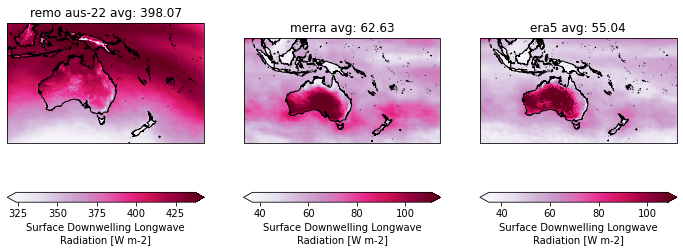

In [19]:
ax = plot_comprison("rlds", remo_oz_dset, -merra_dset, era5_dset)

# Shortwave radiations for Oz

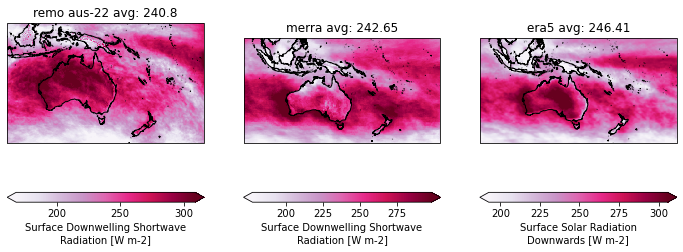

In [15]:
ax = plot_comprison("rsds", remo_oz_dset, merra_dset, era5_dset)

# Calculate Net Longwave radiations in Remo and compare

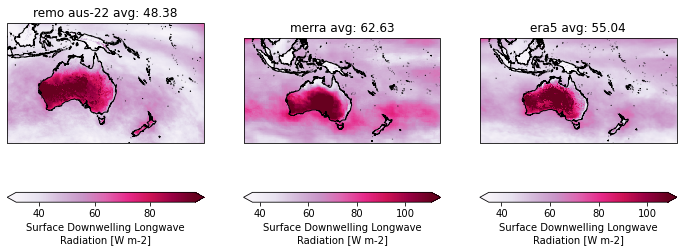

In [29]:
remo_oz_dset["rlds"].data = remo_oz_dset["rlus"].data - remo_oz_dset["rlds"].data
ax = plot_comprison("rlds", remo_oz_dset, -merra_dset, era5_dset)

# Longwave radiations for Eur

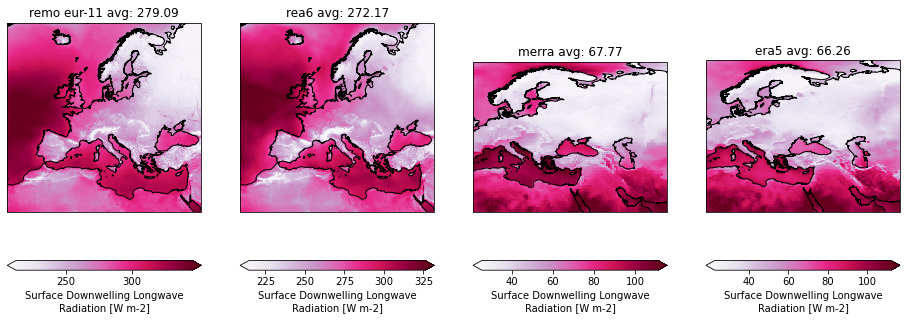

In [20]:
ax = plot_comprison("rlds", remo_eu_dset, rea6_dset, -merra_dset, era5_dset)

# Shortwave radiations for Eur

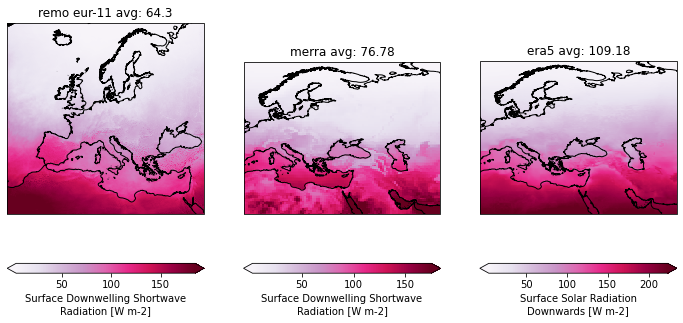

In [18]:
ax = plot_comprison("rsds", remo_eu_dset, merra_dset, era5_dset)

## Observations

* ERA5 seems to have the opposite sign to merra
* Looking at the pattern over the Maritime Continent during the Monsoon Season (Jan) I'd say we are looking at net (downward + upward) radiation fluxes for merra and era5.